In [1]:
# Parameters
# Image
height = 36
width = 128
output = 6

# Architecture
channels_L1 = 10
channels_L2 = 50
max_pool1_stride = 2
max_pool2_stride = 2
final_image_length = int(height / max_pool1_stride / max_pool2_stride)
final_image_width = int(width / max_pool1_stride / max_pool2_stride)

# Training
batch_size = 192
learning_rate = 0.001
num_epochs = 200

In [2]:
# Imports
import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from sklearn import metrics
import seaborn as sns

# LSTM-CNN Architecture

Architecture taken from:
Xia, K., Huang, J., & Wang, H. (2020). LSTM-CNN architecture for human activity recognition. IEEE Access, 8, 56855-56866.

In [5]:
class LSTM_CNN(nn.Module):
    def __init__(self, input_size, width, output_size):
        super().__init__()
        self.input_size  = input_size
        self.width = width
        self.output_size = output_size
        
        # LAYERS
        self.lstm = nn.LSTM(self.input_size, self.input_size, num_layers = 2)
        self.conv1 = nn.Conv2d(1, 64, kernel_size = 5, stride = 2)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1)
        self.globalavgpool = nn.AvgPool2d(kernel_size = (self.width//2 - 6, self.input_size//2 - 6))
        self.batchnorm = nn.BatchNorm1d(128)
        self.fc1 = nn.Linear(128, self.output_size)
        self.softmax = nn.Softmax(dim = 1)
    
    def forward(self, x):
        x = torch.squeeze(x)
        self.batch_size, self.height, self.width = x.shape
        x = x.reshape(self.width, self.batch_size, self.height)
        x, _ = self.lstm(x)
        x = x.reshape(self.batch_size, 1, self.width, self.height)
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.globalavgpool(x)
        x = torch.squeeze(x)
        x = self.batchnorm(x)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

### Training on UCI
* Window size: 128
* Inputs: 9 (transformed to 36 in preprocessing using Junyi's variant of Jiang and Yin's algorithm)
* Activities: 6

In [6]:
# Parameters
# Image
height = 36
width = 128
output = 6

# Training
batch_size = 10
learning_rate = 0.001
num_epochs = 35

In [7]:
UCI_train_features_raw = np.load('../Data/Processed/UCI/RawSignal/UCI_train_features_raw.npy', allow_pickle=True)
UCI_train_labels_raw = np.load('../Data/Processed/UCI/RawSignal/UCI_train_labels.npy', allow_pickle=True)
UCI_test_features_raw = np.load('../Data/Processed/UCI/RawSignal/UCI_test_features_raw.npy', allow_pickle=True)
UCI_test_labels_raw = np.load('../Data/Processed/UCI/RawSignal/UCI_test_labels.npy', allow_pickle=True)

# Subtract 1 for every label for correct training, i.e., [1,2,3,4,5,6] to [0,1,2,3,4,5]
UCI_train_labels_raw = UCI_train_labels_raw.astype(int) - 1
UCI_test_labels_raw = UCI_test_labels_raw.astype(int) - 1

# Transform to torch tensor
tensor_UCI_train_features_raw = torch.Tensor(UCI_train_features_raw)
tensor_UCI_train_labels_raw = torch.Tensor(UCI_train_labels_raw)
tensor_UCI_test_features_raw = torch.Tensor(UCI_test_features_raw) 
tensor_UCI_test_labels_raw = torch.Tensor(UCI_test_labels_raw)

# Add one dimension of channel
tensor_UCI_train_features_raw = torch.unsqueeze(tensor_UCI_train_features_raw, 1)
tensor_UCI_test_features_raw = torch.unsqueeze(tensor_UCI_test_features_raw, 1)

# Create datset
train_dataset_UCI_raw = TensorDataset(tensor_UCI_train_features_raw, tensor_UCI_train_labels_raw)
test_dataset_UCI_raw = TensorDataset(tensor_UCI_test_features_raw, tensor_UCI_test_labels_raw)

train_loader_raw = torch.utils.data.DataLoader(dataset=train_dataset_UCI_raw, batch_size=batch_size, shuffle=True)
test_loader_raw = torch.utils.data.DataLoader(dataset=test_dataset_UCI_raw, batch_size=batch_size, shuffle=False)

In [25]:
# LSTM TRAINING
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTM_CNN(height, width, output).to(device) #GPU

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader_raw)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader_raw):
        # Run the forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device).long())
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels.to(device).long()).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          np.array(acc_list[-100:]).mean()*100))

Epoch [1/35], Step [100/736], Loss: 1.3420, Accuracy: 49.10%
Epoch [1/35], Step [200/736], Loss: 1.1708, Accuracy: 66.10%
Epoch [1/35], Step [300/736], Loss: 1.3200, Accuracy: 74.90%
Epoch [1/35], Step [400/736], Loss: 1.2701, Accuracy: 75.80%
Epoch [1/35], Step [500/736], Loss: 1.0917, Accuracy: 79.30%
Epoch [1/35], Step [600/736], Loss: 1.1843, Accuracy: 81.50%
Epoch [1/35], Step [700/736], Loss: 1.0510, Accuracy: 82.60%
Epoch [2/35], Step [100/736], Loss: 1.1215, Accuracy: 84.80%
Epoch [2/35], Step [200/736], Loss: 1.1571, Accuracy: 87.30%
Epoch [2/35], Step [300/736], Loss: 1.3245, Accuracy: 87.80%
Epoch [2/35], Step [400/736], Loss: 1.3369, Accuracy: 85.10%
Epoch [2/35], Step [500/736], Loss: 1.2227, Accuracy: 85.20%
Epoch [2/35], Step [600/736], Loss: 1.0455, Accuracy: 86.60%
Epoch [2/35], Step [700/736], Loss: 1.4972, Accuracy: 87.50%
Epoch [3/35], Step [100/736], Loss: 1.1803, Accuracy: 87.00%
Epoch [3/35], Step [200/736], Loss: 1.3251, Accuracy: 84.60%
Epoch [3/35], Step [300/

Epoch [20/35], Step [200/736], Loss: 1.0503, Accuracy: 92.90%
Epoch [20/35], Step [300/736], Loss: 1.0905, Accuracy: 93.70%
Epoch [20/35], Step [400/736], Loss: 1.0548, Accuracy: 92.70%
Epoch [20/35], Step [500/736], Loss: 1.0437, Accuracy: 93.60%
Epoch [20/35], Step [600/736], Loss: 1.0436, Accuracy: 93.60%
Epoch [20/35], Step [700/736], Loss: 1.2008, Accuracy: 94.80%
Epoch [21/35], Step [100/736], Loss: 1.0535, Accuracy: 94.80%
Epoch [21/35], Step [200/736], Loss: 1.1188, Accuracy: 94.20%
Epoch [21/35], Step [300/736], Loss: 1.0436, Accuracy: 92.80%
Epoch [21/35], Step [400/736], Loss: 1.1436, Accuracy: 93.00%
Epoch [21/35], Step [500/736], Loss: 1.0436, Accuracy: 94.20%
Epoch [21/35], Step [600/736], Loss: 1.0470, Accuracy: 93.40%
Epoch [21/35], Step [700/736], Loss: 1.1429, Accuracy: 95.00%
Epoch [22/35], Step [100/736], Loss: 1.0436, Accuracy: 94.10%
Epoch [22/35], Step [200/736], Loss: 1.0437, Accuracy: 95.10%
Epoch [22/35], Step [300/736], Loss: 1.1383, Accuracy: 94.40%
Epoch [2

Test Accuracy of the model on the UCI test images: 91.24533423820834 %


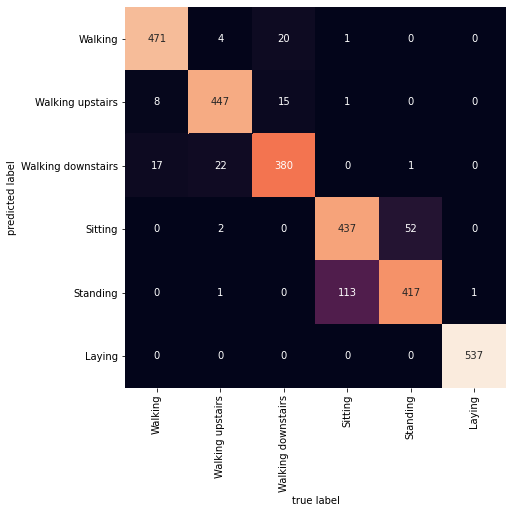

In [26]:
# Test the model
classes = ['Walking', 'Walking upstairs', 'Walking downstairs', 'Sitting', 'Standing', 'Laying']
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_raw:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.append(predicted)
        all_labels.append(labels)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

    print('Test Accuracy of the model on the UCI test images: {} %'.format((correct / total) * 100))

mat = metrics.confusion_matrix(torch.cat(all_predictions).cpu(), torch.cat(all_labels).cpu())
plt.figure(figsize=(7,7))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Training on UTD
* Window size: 128
* Input size: 6 (transformed to 36 in preprocessing)
* Output size: 21

In [36]:
# Parameters
# Image
height = 18
width = 128
output = 21

# Training
batch_size = 5
learning_rate = 0.001
num_epochs = 100

In [10]:
UTD_train_features_raw = np.load('../Data/Processed/UTD/train_UTD_features_raw.npy', allow_pickle=True)
UTD_train_labels_raw = np.load('../Data/Processed/UTD/train_UTD_labels_raw.npy', allow_pickle=True)
UTD_test_features_raw = np.load('../Data/Processed/UTD/test_UTD_features_raw.npy', allow_pickle=True)
UTD_test_labels_raw = np.load('../Data/Processed/UTD/test_UTD_labels_raw.npy', allow_pickle=True)

# Subtract 1 for every label for correct training, i.e., [1,2,3,4,5,6] to [0,1,2,3,4,5]
UTD_train_labels_raw = UTD_train_labels_raw.astype(int) - 1
UTD_test_labels_raw = UTD_test_labels_raw.astype(int) - 1

# Transform to torch tensor
tensor_UTD_train_features_raw = torch.Tensor(UTD_train_features_raw)
tensor_UTD_train_labels_raw = torch.Tensor(UTD_train_labels_raw)
tensor_UTD_test_features_raw = torch.Tensor(UTD_test_features_raw) 
tensor_UTD_test_labels_raw = torch.Tensor(UTD_test_labels_raw)

# Add one dimension of channel
tensor_UTD_train_features_raw = torch.unsqueeze(tensor_UTD_train_features_raw, 1)
tensor_UTD_test_features_raw = torch.unsqueeze(tensor_UTD_test_features_raw, 1)

# Create datset
train_dataset_UTD_raw = TensorDataset(tensor_UTD_train_features_raw, tensor_UTD_train_labels_raw)
test_dataset_UTD_raw = TensorDataset(tensor_UTD_test_features_raw, tensor_UTD_test_labels_raw)

train_loader_UTD_raw = torch.utils.data.DataLoader(dataset=train_dataset_UTD_raw, batch_size=batch_size, shuffle=True)
test_loader_UTD_raw = torch.utils.data.DataLoader(dataset=test_dataset_UTD_raw, batch_size=batch_size, shuffle=False)

In [53]:
# LSTM TRAINING
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTM_CNN(height, width, output).to(device) #GPU

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader_UTD_raw)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader_UTD_raw):
        # Run the forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device).long())
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels.to(device).long()).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 50 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          np.array(acc_list[-100:]).mean()*100))

Epoch [1/100], Step [50/104], Loss: 2.9055, Accuracy: 9.60%
Epoch [1/100], Step [100/104], Loss: 2.9007, Accuracy: 10.20%
Epoch [2/100], Step [50/104], Loss: 2.9149, Accuracy: 16.00%
Epoch [2/100], Step [100/104], Loss: 2.7970, Accuracy: 23.00%
Epoch [3/100], Step [50/104], Loss: 3.0418, Accuracy: 27.80%
Epoch [3/100], Step [100/104], Loss: 2.8637, Accuracy: 28.80%
Epoch [4/100], Step [50/104], Loss: 2.8374, Accuracy: 31.65%
Epoch [4/100], Step [100/104], Loss: 2.8425, Accuracy: 33.40%
Epoch [5/100], Step [50/104], Loss: 3.0677, Accuracy: 37.05%
Epoch [5/100], Step [100/104], Loss: 2.7906, Accuracy: 36.80%
Epoch [6/100], Step [50/104], Loss: 2.9048, Accuracy: 35.05%
Epoch [6/100], Step [100/104], Loss: 3.0300, Accuracy: 40.80%
Epoch [7/100], Step [50/104], Loss: 2.7294, Accuracy: 45.30%
Epoch [7/100], Step [100/104], Loss: 2.8936, Accuracy: 47.60%
Epoch [8/100], Step [50/104], Loss: 2.7225, Accuracy: 46.10%
Epoch [8/100], Step [100/104], Loss: 2.5067, Accuracy: 47.80%
Epoch [9/100], St

Epoch [67/100], Step [50/104], Loss: 2.2970, Accuracy: 95.15%
Epoch [67/100], Step [100/104], Loss: 2.1245, Accuracy: 95.20%
Epoch [68/100], Step [50/104], Loss: 2.1233, Accuracy: 95.15%
Epoch [68/100], Step [100/104], Loss: 2.1234, Accuracy: 93.60%
Epoch [69/100], Step [50/104], Loss: 2.1333, Accuracy: 92.45%
Epoch [69/100], Step [100/104], Loss: 2.3104, Accuracy: 93.20%
Epoch [70/100], Step [50/104], Loss: 2.1473, Accuracy: 91.30%
Epoch [70/100], Step [100/104], Loss: 2.1270, Accuracy: 93.20%
Epoch [71/100], Step [50/104], Loss: 2.1286, Accuracy: 93.45%
Epoch [71/100], Step [100/104], Loss: 2.1236, Accuracy: 93.00%
Epoch [72/100], Step [50/104], Loss: 2.1260, Accuracy: 92.30%
Epoch [72/100], Step [100/104], Loss: 2.1390, Accuracy: 93.60%
Epoch [73/100], Step [50/104], Loss: 2.3428, Accuracy: 92.15%
Epoch [73/100], Step [100/104], Loss: 2.2722, Accuracy: 91.20%
Epoch [74/100], Step [50/104], Loss: 2.1437, Accuracy: 91.50%
Epoch [74/100], Step [100/104], Loss: 2.1489, Accuracy: 91.20%


Test Accuracy of the model on the UCI test images: 60.76923076923077 %


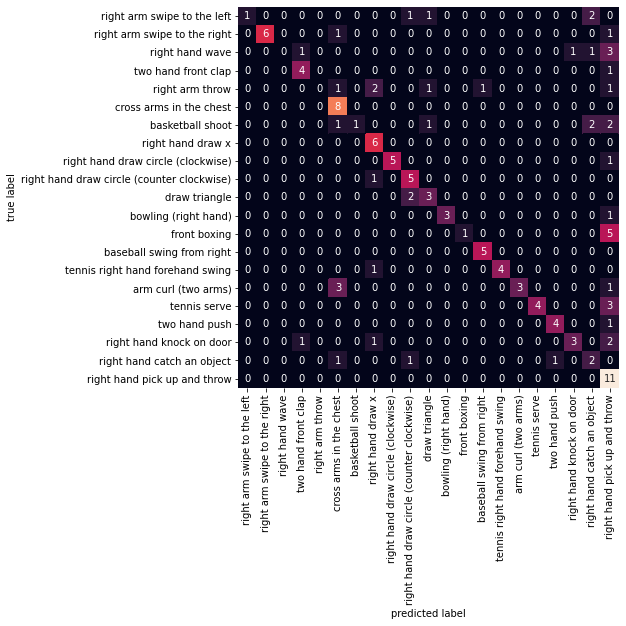

In [54]:
# Test the model
classes = ['right arm swipe to the left', 
           'right arm swipe to the right', 
           'right hand wave', 
           'two hand front clap', 'right arm throw',
           'cross arms in the chest',
           'basketball shoot', 
           'right hand draw x', 
           'right hand draw circle (clockwise)', 
           'right hand draw circle (counter clockwise)', 
           'draw triangle', 
           'bowling (right hand)', 
           'front boxing', 
           'baseball swing from right', 
           'tennis right hand forehand swing', 
           'arm curl (two arms)', 
           'tennis serve', 
           'two hand push', 
           'right hand knock on door', 
           'right hand catch an object', 
           'right hand pick up and throw']
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_UTD_raw:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.append(predicted)
        all_labels.append(labels)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

    print('Test Accuracy of the model on the UTD test images: {} %'.format((correct / total) * 100))

mat = metrics.confusion_matrix(torch.cat(all_predictions).cpu(), torch.cat(all_labels).cpu())
plt.figure(figsize=(7,7))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('predicted label')
plt.ylabel('true label');

### Training on USC
* Window size: 128
* Inputs: 6 (transformed to 18 in preprocessing using Junyi's variant of Jiang and Yin's algorithm)
* Activities: 12

In [11]:
# Parameters
# Image
height = 18
width = 128
output = 12

# Training
batch_size = 10
learning_rate = 0.001
num_epochs = 8

In [12]:
USC_train_features_raw = np.load('../Data/Processed/USC/train_features_USC_raw.npy', allow_pickle=True)
USC_train_labels_raw = np.load('../Data/Processed/USC/train_labels_USC_raw.npy', allow_pickle=True)
USC_test_features_raw = np.load('../Data/Processed/USC/test_features_USC_raw.npy', allow_pickle=True)
USC_test_labels_raw = np.load('../Data/Processed/USC/test_labels_USC_raw.npy', allow_pickle=True)

# Subtract 1 for every label for correct training, i.e., [1,2,3,4,5,6] to [0,1,2,3,4,5]
USC_train_labels_raw = USC_train_labels_raw.astype(int) - 1
USC_test_labels_raw = USC_test_labels_raw.astype(int) - 1

# Transform to torch tensor
tensor_USC_train_features_raw = torch.Tensor(USC_train_features_raw)
tensor_USC_train_labels_raw = torch.Tensor(USC_train_labels_raw)
tensor_USC_test_features_raw = torch.Tensor(USC_test_features_raw) 
tensor_USC_test_labels_raw = torch.Tensor(USC_test_labels_raw)

# Add one dimension of channel
tensor_USC_train_features_raw = torch.unsqueeze(tensor_USC_train_features_raw, 1)
tensor_USC_test_features_raw = torch.unsqueeze(tensor_USC_test_features_raw, 1)

# Create datset
train_dataset_USC_raw = TensorDataset(tensor_USC_train_features_raw, tensor_USC_train_labels_raw)
test_dataset_USC_raw = TensorDataset(tensor_USC_test_features_raw, tensor_USC_test_labels_raw)

train_loader_USC_raw = torch.utils.data.DataLoader(dataset=train_dataset_USC_raw, batch_size=batch_size, shuffle=True)
test_loader_USC_raw = torch.utils.data.DataLoader(dataset=test_dataset_USC_raw, batch_size=batch_size, shuffle=False)

In [13]:
# LSTM TRAINING
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTM_CNN(height, width, output).to(device) #GPU

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader_USC_raw)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader_USC_raw):
        # Run the forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device).long())
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels.to(device).long()).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          np.array(acc_list[-100:]).mean()*100))

Epoch [1/8], Step [200/3073], Loss: 2.3004, Accuracy: 39.50%
Epoch [1/8], Step [400/3073], Loss: 2.2625, Accuracy: 44.40%
Epoch [1/8], Step [600/3073], Loss: 2.0894, Accuracy: 45.50%
Epoch [1/8], Step [800/3073], Loss: 2.3038, Accuracy: 48.90%
Epoch [1/8], Step [1000/3073], Loss: 2.0269, Accuracy: 48.10%
Epoch [1/8], Step [1200/3073], Loss: 2.3029, Accuracy: 51.50%
Epoch [1/8], Step [1400/3073], Loss: 2.0922, Accuracy: 51.20%
Epoch [1/8], Step [1600/3073], Loss: 2.1961, Accuracy: 47.90%
Epoch [1/8], Step [1800/3073], Loss: 2.1288, Accuracy: 54.00%
Epoch [1/8], Step [2000/3073], Loss: 2.2516, Accuracy: 52.90%
Epoch [1/8], Step [2200/3073], Loss: 2.2804, Accuracy: 54.30%
Epoch [1/8], Step [2400/3073], Loss: 2.1086, Accuracy: 56.10%
Epoch [1/8], Step [2600/3073], Loss: 2.2735, Accuracy: 55.90%
Epoch [1/8], Step [2800/3073], Loss: 2.0853, Accuracy: 56.00%
Epoch [1/8], Step [3000/3073], Loss: 2.0430, Accuracy: 57.70%
Epoch [2/8], Step [200/3073], Loss: 2.1704, Accuracy: 56.10%
Epoch [2/8], 

Test Accuracy of the model on the UTD test images: 74.72093553041233 %


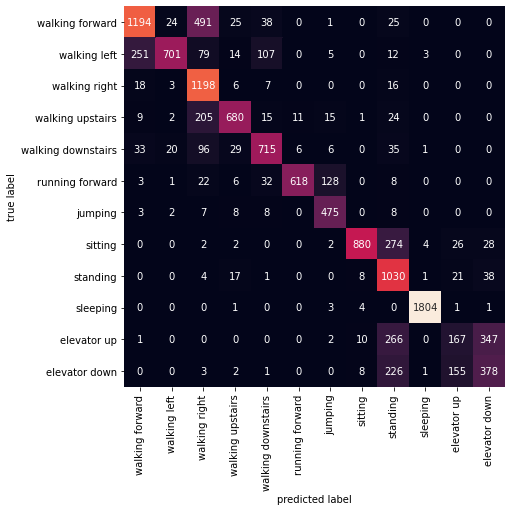

In [15]:
# Test the model
classes = ['walking forward', 
           'walking left', 
           'walking right', 
           'walking upstairs', 
           'walking downstairs',
           'running forward', 
           'jumping', 
           'sitting', 
           'standing', 
           'sleeping', 
           'elevator up', 
           'elevator down']

model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_USC_raw:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.append(predicted)
        all_labels.append(labels)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

    print('Test Accuracy of the model on the UTD test images: {} %'.format((correct / total) * 100))

mat = metrics.confusion_matrix(torch.cat(all_predictions).cpu(), torch.cat(all_labels).cpu())
plt.figure(figsize=(7,7))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('predicted label')
plt.ylabel('true label');